In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import cv2 as cv
import numpy as np
import os

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Rutas importantes
dataset_path = '/content/dataset/dataset'
models_path = '/content/drive/MyDrive/TFM/models'
img_type = 'equalHist'
model_name = f'2Img_{img_type}_Tab'


Mounted at /content/drive


In [ ]:
rm -rf "/content/dataset"


In [ ]:
!unzip "/content/drive/MyDrive/TFM/dataset.zip" -d "/content/dataset" > /dev/null 2>&1

In [ ]:
# Ruta al dataset
data_dir= f'{dataset_path}/imagenes'

img_height, img_width = 20, 20

# Listar y cargar imágenes
image_array = []

def numeric_sort_key(filename,label):
    return int(os.path.splitext(filename)[0].replace(f"_{label}",""))  # Extrae el número del nombre antes del '.jpg'

for label in ["estrellas","galaxias"]:

    data_dir_label = data_dir + "/" + label

    file_names = sorted(os.listdir(data_dir_label), key= lambda x: numeric_sort_key(x,label))
    print(len(file_names))

    for fname in file_names:

        if fname.endswith(('.png', '.jpg', '.jpeg')):

          img_path = os.path.join(data_dir_label, fname)
          img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
          img_array = tf.keras.utils.img_to_array(img)
          image_array.append(img_array)

# Convertir a array de NumPy
X_images = np.array(image_array, dtype="float32") / 255.0



# Ruta al dataset
data_dir= f'{dataset_path}/imagenes_clean_{img_type}'

# Listar y cargar imágenes
image_array = []

def numeric_sort_key(filename,label):
    return int(os.path.splitext(filename)[0].replace(f"_{label}",""))  # Extrae el número del nombre antes del '.jpg'

for label in ["estrellas","galaxias"]:

    data_dir_label = data_dir + "/" + label

    file_names = sorted(os.listdir(data_dir_label), key= lambda x: numeric_sort_key(x,label))
    print(len(file_names))

    for fname in file_names:

        if fname.endswith(('.png', '.jpg', '.jpeg')):

          img_path = os.path.join(data_dir_label, fname)
          img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
          img_array = tf.keras.utils.img_to_array(img)
          image_array.append(img_array)

# Convertir a array de NumPy
X_images_processed = np.array(image_array, dtype="float32") / 255.0

10000
10000
10000
10000


In [ ]:
file_name_galaxias = f"galaxias_10000_extended.csv"
file_name_estrellas= f"estrellas_10000_extended.csv"

df_galaxias = pd.read_csv(f"{dataset_path}/fotometria/conformed/{file_name_galaxias}", index_col=False).sort_values("id",ascending=True)
df_estrellas = pd.read_csv(f"{dataset_path}/fotometria/conformed/{file_name_estrellas}", index_col=False).sort_values("id",ascending=True)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_all = pd.concat([df_estrellas,df_galaxias],axis=0).drop(["ra","dec","flags_r","id"], axis=1)

y = df_all["label"].values
# X_tabular = pd.DataFrame(scaler.fit_transform(df_all.drop(["label"],axis=1)),columns=df_all.drop(["label"],axis=1).columns)

X_tabular = scaler.fit_transform(df_all.drop(["label"],axis=1))


In [ ]:
# Generar una permutación aleatoria
np.random.seed(15)
perm = np.random.permutation(len(y))

# Aplicar la misma permutación a ambos arrays
X_tabular_shuffled = X_tabular[perm]
X_images_shuffled = X_images[perm]
X_images_processed_shuffled = X_images_processed[perm]
y_shuffled = y[perm]

train_per = int(round(len(y)*0.7))
valid_per = int(round(len(y)*0.15))
test_per = int(round(len(y)*0.15))

X_train, y_train = [X_images_shuffled[:train_per], X_images_processed_shuffled[:train_per], X_tabular_shuffled[:train_per]], y_shuffled[:train_per]
X_valid, y_valid = [X_images_shuffled[train_per:train_per + valid_per], X_images_processed_shuffled[train_per:train_per + valid_per], X_tabular_shuffled[train_per:train_per + valid_per]], y_shuffled[train_per:train_per + valid_per]
X_test, y_test = [X_images_shuffled[train_per + valid_per:], X_images_processed_shuffled[train_per + valid_per:], X_tabular_shuffled[train_per + valid_per:]], y_shuffled[train_per + valid_per:]

In [ ]:
from tensorflow.keras import layers, models, Input
from keras import regularizers, saving
from tensorflow.keras.optimizers import SGD, Nadam, Adam, AdamW, RMSprop
import tensorflow as tf


def convolutional_attention_block(input_tensor):
    """Atención espacial usando operaciones convolucionales"""

    # Asume que input_tensor tiene shape (None, H, W, C)
    @saving.register_keras_serializable()
    def channel_avg(x):
        return tf.reduce_mean(x, axis=3, keepdims=True)

    @saving.register_keras_serializable()
    def channel_max(x):
        return tf.reduce_max(x, axis=3, keepdims=True)

    @saving.register_keras_serializable()
    def output_shape(input_shape):
        return (input_shape[0], input_shape[1], input_shape[2], 1)

    avg_pool = layers.Lambda(channel_avg, output_shape=output_shape)(input_tensor)
    max_pool = layers.Lambda(channel_max, output_shape=output_shape)(input_tensor)

    # Concatenar y aplicar convolución
    concat = layers.Concatenate(axis=3)([avg_pool, max_pool])
    attention = layers.Conv2D(1, (7, 7), padding='same', activation='sigmoid')(concat)

    return layers.Multiply()([input_tensor, attention])

# Entrada 1: imágenes RGB
image_input = Input(shape=(img_height, img_width, 3), name='image_input')

# Data Augmentation
x = layers.RandomRotation(0.2)(image_input)
x = layers.RandomZoom(0.2)(x)
x = layers.RandomContrast(0.2)(x)
x = layers.RandomTranslation(0.2, 0.2)(x)


# Bloque 1 con atención
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = convolutional_attention_block(x)  # Atención aquí
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

# Bloque 2
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = convolutional_attention_block(x)  # Atención aquí
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

# Bloque 3
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = convolutional_attention_block(x)  # Atención aquí
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.GlobalAveragePooling2D()(x)


# Entrada 2: imágenes RGB
image_processed_input = Input(shape=(img_height, img_width, 3), name='image_processed_input')

# Data Augmentation
y = layers.RandomRotation(0.2)(image_processed_input)
y = layers.RandomZoom(0.2)(y)
y = layers.RandomContrast(0.2)(y)
y = layers.RandomTranslation(0.2, 0.2)(y)

# Bloque 1 con atención
y = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(y)
y = convolutional_attention_block(y)  # Atención aquí
y = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(y)
y = layers.BatchNormalization()(y)
y = layers.MaxPooling2D((2, 2))(y)

# Bloque 2
y = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(y)
y = convolutional_attention_block(y)  # Atención aquí
y = layers.BatchNormalization()(y)
y = layers.MaxPooling2D((2, 2))(y)

# Bloque 3
y = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(y)
y = convolutional_attention_block(y)  # Atención aquí
y = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(y)
y = layers.BatchNormalization()(y)
y = layers.GlobalAveragePooling2D()(y)

# Entrada 3: datos adicionales
numeric_input = Input(shape=(15,), name='numeric_input')
numeric_branch = layers.Dense(250, activation='relu')(numeric_input)

# Concatenación de salidas
combined = layers.concatenate([x, y, numeric_branch])

# Red densa final
z = layers.Dense(500, activation='relu')(combined)
z = layers.Dropout(0.4)(z)
z = layers.Dense(1000, activation='relu', kernel_regularizer=regularizers.L2(1e-4))(z)
z = layers.Dropout(0.5)(z)
z = layers.Dense(500, activation='relu', kernel_regularizer=regularizers.L2(1e-4))(z)
z = layers.Dropout(0.4)(z)
output = layers.Dense(1, activation='sigmoid')(z)

# Modelo completo
model = models.Model(inputs=[image_input, image_processed_input, numeric_input], outputs=output)

# Compilar
# optimizer = SGD(learning_rate=0.01, momentum=0.9)
# optimizer = Nadam()
optimizer = Adam(learning_rate=1e-3)
# optimizer = RMSprop(learning_rate=1e-5, rho=0.9, momentum=0.9)
# optimizer = AdamW(learning_rate=1e-4, weight_decay=1e-4)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 20, 20, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_processed_in… │ (None, 20, 20, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation_2   │ (None, 20, 20, 3) │          0 │ image_input[0][0] │
│ (RandomRotation)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation_3   │ (None, 20, 20, 3) │          0 │ image_processed_… │
│ (RandomRotation)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_zoom_2       │ (None, 20, 20, 3) │          0 │ random_rotation_… │
│ (RandomZoom)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_zoom_3       │ (None, 20, 20, 3) │          0 │ random_rotation_… │
│ (RandomZoom)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_contrast_2   │ (None, 20, 20, 3) │          0 │ random_zoom_2[0]… │
│ (RandomContrast)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_contrast_3   │ (None, 20, 20, 3) │          0 │ random_zoom_3[0]… │
│ (RandomContrast)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_translation… │ (None, 20, 20, 3) │          0 │ random_contrast_… │
│ (RandomTranslation) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_translation… │ (None, 20, 20, 3) │          0 │ random_contrast_… │
│ (RandomTranslation) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 20, 20,    │        896 │ random_translati… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 20, 20,    │        896 │ random_translati… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_12 (Lambda)  │ (None, 20, 20, 1) │          0 │ conv2d_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_13 (Lambda)  │ (None, 20, 20, 1) │          0 │ conv2d_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_18 (Lambda)  │ (None, 20, 20, 1) │          0 │ conv2d_24[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_19 (Lambda)  │ (None, 20, 20, 1) │          0 │ conv2d_24[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 20, 20, 2) │          0 │ lambda_12[0][0],  │
│ (Concatenate)       │                   │            │ lambda_13[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 20, 20, 2) │          0 │ lambda_18[0][0],  │
│ (Concatenate)       │                   │            │ lambda_19[0][0] 

 Total params: 2,629,567 (10.03 MB)

 Trainable params: 2,628,287 (10.03 MB)

 Non-trainable params: 1,280 (5.00 KB)

Epoch 1/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.7437 - auc_1: 0.8258 - loss: 0.6247 - precision_1: 0.7288 - recall_1: 0.7791 - val_accuracy: 0.5080 - val_auc_1: 0.6219 - val_loss: 0.8236 - val_precision_1: 1.0000 - val_recall_1: 0.0147 - learning_rate: 0.0010
Epoch 2/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8051 - auc_1: 0.8986 - loss: 0.4851 - precision_1: 0.8070 - recall_1: 0.8064 - val_accuracy: 0.5323 - val_auc_1: 0.7861 - val_loss: 1.6939 - val_precision_1: 0.5165 - val_recall_1: 0.9900 - learning_rate: 0.0010
Epoch 3/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8358 - auc_1: 0.9226 - loss: 0.4095 - precision_1: 0.8447 - recall_1: 0.8213 - val_accuracy: 0.8830 - val_auc_1: 0.9564 - val_loss: 0.3297 - val_precision_1: 0.9002 - val_recall_1: 0.8611 - learning_rate: 0.0010
Epoch 4/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8467 - auc_1: 0.9336 - loss: 0.3658 - precision_1: 0.8787 - recall_1: 0.8047 - val_accuracy

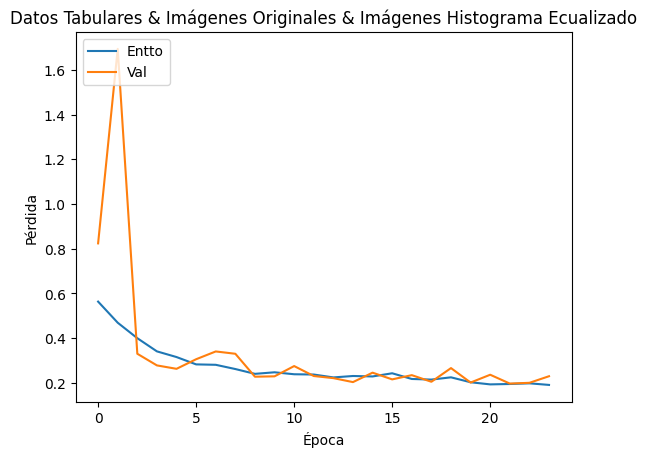

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_accuracy',      # Métrica a monitorear (puede ser 'val_accuracy', 'val_auc', etc.)
    patience=10,              # Número de epochs sin mejora antes de detener
    restore_best_weights=True,  # Restaura los pesos del mejor epoch
    verbose=1                # Muestra un mensaje cuando se detiene
)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

history = model.fit(X_train, y_train, epochs=100, batch_size=50, validation_data=(X_valid, y_valid), callbacks=[lr_scheduler,early_stopping])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Datos Tabulares & Imágenes Originales & Imágenes Histograma Ecualizado')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entto', 'Val'], loc='upper left')
plt.show()

model.save(f"{models_path}/{model_name}.keras")

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9222 - auc_1: 0.9756 - loss: 0.1977 - precision_1: 0.9456 - recall_1: 0.8881
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
              precision    recall  f1-score   support

   Estrellas       0.90      0.94      0.92      1527
    Galaxias       0.94      0.89      0.91      1473

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000



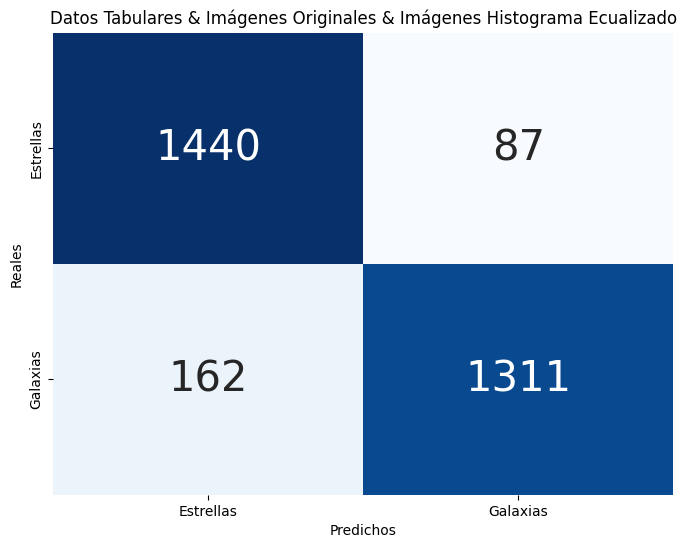

,,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,modelFlux_u,modelFlux_g,modelFlux_r,modelFlux_i,modelFlux_z
y_true,y_pred,,,,,,,,,,,,,,,
0,1,0.732054,0.739131,0.689148,0.677001,0.769748,0.605789,0.626398,0.652433,0.432712,0.54241,0.013655,0.001190,0.000806,0.051356,0.018151
1,0,0.746872,0.750629,0.702979,0.694228,0.769208,0.628455,0.641946,0.672254,0.451018,0.55131,0.013422,0.001211,0.000748,0.051125,0.018068


,,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,modelFlux_u,modelFlux_g,modelFlux_r,modelFlux_i,modelFlux_z
y_true,y_pred,,,,,,,,,,,,,,,
0,0,0.663800,0.620076,0.571343,0.553336,0.625473,0.554582,0.533910,0.553238,0.360874,0.448743,0.022744,0.015613,0.019862,0.070251,0.031477
1,1,0.711015,0.708959,0.662557,0.651642,0.730859,0.566970,0.573037,0.591830,0.393229,0.493497,0.014611,0.002421,0.002754,0.053444,0.019713


Index([6, 9, 31], dtype='int64')


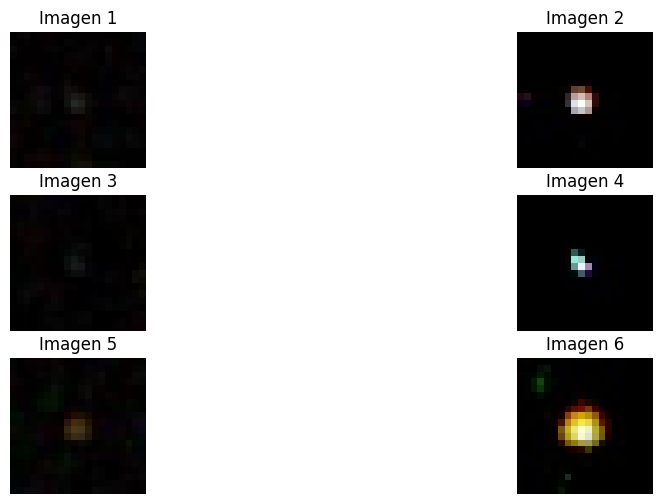

In [ ]:
from tensorflow.keras.models import load_model
from keras.saving import register_keras_serializable

@register_keras_serializable()
def channel_avg(x):
    return tf.reduce_mean(x, axis=3, keepdims=True)

@register_keras_serializable()
def channel_max(x):
    return tf.reduce_max(x, axis=3, keepdims=True)

@register_keras_serializable()
def output_shape(input_shape):
    return (input_shape[0], input_shape[1], input_shape[2], 1)

model = load_model(
    f"{models_path}/{model_name}.keras",
    custom_objects={
        "channel_avg": channel_avg,
        "channel_max": channel_max,
        "output_shape": output_shape
    }
)

model.evaluate(X_test, y_test)

# Predicciones del modelo:
y_pred_probs = model.predict(X_test)
y_pred_labels = list(map(lambda x: 0 if x <= 0.5 else 1, y_pred_probs))

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_labels, target_names=["Estrellas","Galaxias"]))

import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=["Estrellas","Galaxias"], yticklabels=["Estrellas","Galaxias"], cmap='Blues', cbar=False, annot_kws={'size': 30})
plt.xlabel('Predichos')
plt.ylabel('Reales')
plt.title('Datos Tabulares & Imágenes Originales & Imágenes Histograma Ecualizado')
plt.show()

df_pred = pd.DataFrame(X_test[2],columns=df_all.columns.drop("label"))
df_pred["y_true"] = y_test
df_pred["y_pred"] = y_pred_labels

df_wrong = df_pred[df_pred["y_true"] != df_pred["y_pred"]]
df_well = df_pred[df_pred["y_true"] == df_pred["y_pred"]]

display(df_wrong.groupby(["y_true","y_pred"]).mean())
display(df_well.groupby(["y_true","y_pred"]).mean())

imgs_wrong = X_test[0][df_wrong.index]
imgs_processed_wrong = X_test[1][df_wrong.index]

print(df_wrong.index[:3])

# Crear figura y ejes
fig, axs = plt.subplots(3, 2, figsize=(12, 6))

# Iterar y mostrar cada imagen
for i, ax in enumerate(axs.flat):
    if i%2 == 0:
        ax.imshow(imgs_wrong[int(i/2)])
    else:
        ax.imshow(imgs_processed_wrong[int((i-1)/2)])
    ax.set_title(f'Imagen {i+1}')
    ax.axis('off')  # Ocultar ejes

In [ ]:
perm[train_per + valid_per + 0:]


array([17515,  6802, 11536, ...,  2693,  8076,  7624])

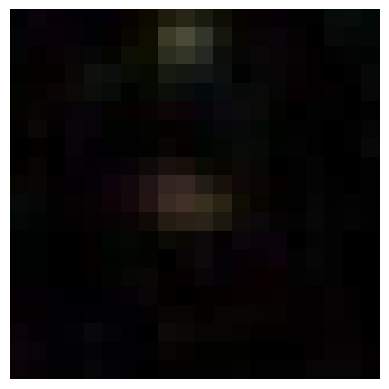

In [ ]:
# Mostrar imagen con matplotlib
plt.imshow(X_test[0][0])
# plt.imshow(X_test[1][498])
plt.axis('off')  # Opcional: quita los ejes
plt.show()

In [3]:
from tensorflow.keras.models import load_model
from keras.saving import register_keras_serializable
from keras.utils import plot_model

@register_keras_serializable()
def channel_avg(x):
    return tf.reduce_mean(x, axis=3, keepdims=True)

@register_keras_serializable()
def channel_max(x):
    return tf.reduce_max(x, axis=3, keepdims=True)

@register_keras_serializable()
def output_shape(input_shape):
    return (input_shape[0], input_shape[1], input_shape[2], 1)

model = load_model(
    f"{models_path}/{model_name}.keras",
    custom_objects={
        "channel_avg": channel_avg,
        "channel_max": channel_max,
        "output_shape": output_shape
    }
)

dot_img_file = f'{models_path}/{model_name}.png'
plot_model(model, to_file=dot_img_file, show_shapes=True)